This code is for a recommender system. The idea is to build a machine learning model to smartly recommend itmes to customers.<br> This model is a weighted model that weights the users' past purchase behavior and his/her similar users' purchase behavior<br>The data is obtaind from https://www.kaggle.com/retailrocket/ecommerce-dataset/data<br>

In [ ]:
import copy
import pandas as pd
import numpy as np
import random
class person:
    """
    The item class, which record the change of the properties and the customer
    of the item
    """
    def __init__(self, id):
        self.person_id = id
        self.purchased_category = {}
        self.viewed_or_carted_category = {}
        self.total_purchased_num = 0
        self.total_viewd_or_carted_num = 0

In [2]:
class analyse():
    """
    the class to read and store data
    """
    def __init__(self):
        self.persons = {}
        self.category_id_dic = {}
        self.category_to_id_dic = {}
    def find_category_id(self, property_file):
        """
        find the corresponding category id for each id
        """
        f, first = open(property_file, "r"), True
        for line in f:
            if first:
                first = False
                continue
            property_info = line.split(",")
            
            item_id, pro_name, value = property_info[1], property_info[2], property_info[3]
            if len(pro_name)>0 and pro_name[-1] == "\n":
                pro_name = pro_name[:-1]
            if pro_name != "categoryid":
                continue
            if len(value)>0 and value[-1] == "\n":
                value = value[:-1]
            if len(item_id)>0 and item_id[-1] == "\n":
                item_id = item_id[:-1]
            self.category_id_dic[item_id] = value
            if value not in self.category_to_id_dic:
                self.category_to_id_dic[value] = []
            self.category_to_id_dic[value].append(item_id)
    def read_event(self, event_file):
        f, first = open(event_file, "r"), True
        count, no_cate = 0, 0
        for line in f:
            if first:
                first = False
                continue
            count += 1
            event_info = line.split(",")
            person_id, event, item_id =  event_info[1], event_info[2], event_info[3]
            category_id = None
            if len(item_id) > 0 and item_id[-1] == "\n":
                item_id = item_id[:-1]
            if item_id not in self.category_id_dic:
                no_cate += 1
                category_id = item_id
            else:
                category_id = self.category_id_dic[item_id]
            if person_id not in self.persons:
                self.persons[person_id] = person(person_id)
            
            if event == "transaction":
                self.persons[person_id].purchased_category[category_id] = self.persons[person_id].purchased_category.get(category_id, 0) + 1
                self.persons[person_id].total_purchased_num += 1
            else:
                self.persons[person_id].viewed_or_carted_category[category_id] = self.persons[person_id].viewed_or_carted_category.get(category_id, 0) + 1
                self.persons[person_id].total_viewd_or_carted_num += 1
        print count, no_cate
data = analyse()
data.find_category_id("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/item_properties_part1.csv")
data.find_category_id("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/item_properties_part2.csv")
data.read_event("/Users/Kiki/Downloads/retailrocket-recommender-system-dataset/events.csv")

2756101 255585


In [3]:
def subset(data, threshold):
    """
    preprocess users in a, filter the users according to its purchased, viewd, and carted items
    :param threshold: int
    :return: {}
    """
    res = {}
    for p_name, person in data.persons.items():
        if person.total_purchased_num > threshold and person.total_viewd_or_carted_num > threshold:
            res[p_name] = copy.deepcopy(person)
    return res

In [4]:
subset_persons = subset(data, 2)

print len(subset_persons.keys())

1016


In [5]:
def category(persons):
    """
    give back a list of category given the persons
    :param persons: dic
    :return: []
    """
    res = []
    dic = {}
    
    for p_name, person in persons.items():
        
        for category_id in person.purchased_category:
            if category_id not in dic:
                res.append(category_id)
                dic[category_id] = True
        for category_id in person.viewed_or_carted_category:
            if category_id not in dic:
                res.append(category_id)
                dic[category_id] = True
    
    return res

In [6]:
subset_category = category(subset_persons)

In [7]:
def tr_te_sets(persons):
    """
    divide data to training and testing set
    :param persons: dict
    :return: {}, {}
    """
    ran_list, tr_set, te_set  = [], {}, {}
    for p_name, person_object in persons.items():
        for category_id in person_object.purchased_category:
            if p_name not in tr_set:
                tr_set[p_name] = person(p_name)
                tr_set[p_name].purchased_category[category_id] = person_object.purchased_category[category_id]
                
            else:
                ran_num = round(random.uniform(0, 1),2)
                if ran_num < 0.2:
                    if p_name not in te_set:
                        te_set[p_name] = person(p_name)
                    te_set[p_name].purchased_category[category_id] = person_object.purchased_category[category_id]
                else:
                    tr_set[p_name].purchased_category[category_id] = person_object.purchased_category[category_id]
        for category_id in person_object.viewed_or_carted_category:
            ran_num = round(random.uniform(0, 1),2)
            if ran_num < 0.2:
                if p_name not in te_set:
                    te_set[p_name] = person(p_name)
                te_set[p_name].purchased_category[category_id] = person_object.viewed_or_carted_category[category_id]
            else:
                tr_set[p_name].purchased_category[category_id] = person_object.viewed_or_carted_category[category_id]
    
    return tr_set, te_set

In [8]:
tr_set, te_set = tr_te_sets(subset_persons)
f = open("tr_set.txt","w") 
f.write(str(tr_set))
f = open("te_set.txt","w") 
f.write(str(te_set))

In [9]:
def cal_score(persons, categories):
    """
    give back a scores dictionary recording the score of each category for each person
    :param persons: dic
    :param categories: list
    :return: {}
    """
    scores = {}
    for p_name, person in persons.items():
        scores[p_name], total = {}, 0
        for c_id in categories:
            scores[p_name][c_id] = 0
        for c_id, times in person.purchased_category.items():
            scores[p_name][c_id]  += times
            total += times
        for c_id, times in person.viewed_or_carted_category.items():
            scores[p_name][c_id] += 0.5 * times
            total += 0.5 * times
        for k in scores[p_name]:
            scores[p_name][k] = (scores[p_name][k]*1.0/total)
        
    return scores
        

In [10]:
tr_scores = cal_score(tr_set, subset_category)
te_scores = cal_score(te_set, subset_category)

In [62]:
f = open("tr_scores.txt","w") 
f.write(str(tr_scores))
f = open("te_scores.txt","w") 
f.write(str(te_scores))

In [63]:
def create_table(scores, categories):
    """
    create a scores table
    :param scores: dic
    :param categories: list
    :return: {}
    """
    persons_names = scores.keys()
    categories
    person_list = []
    category_list = []
    score_list = []
    for person_name in persons_names:
        for c_id in categories:
            person_list.append(person_name)
            category_list.append(c_id)
            score_list.append(scores[person_name][c_id])
    dic = {"person" : person_list, 'categoryid':category_list, 'score':score_list}
    return pd.DataFrame(dic,columns=['person','categoryid','score'])

    

In [64]:
tr_df = create_table(tr_scores, subset_category)
te_df = create_table(te_scores, subset_category)

In [65]:
tr_df.head()

,person,categoryid,score
0,625795,1421,0.055556
1,625795,618,0.004630
2,625795,619,0.009259
3,625795,352,0.009259
4,625795,1261,0.004630


In [66]:
te_df.head()

,person,categoryid,score
0,625795,1421,0.000000
1,625795,618,0.433962
2,625795,619,0.000000
3,625795,352,0.000000
4,625795,1261,0.000000


In [11]:
import math
def pearson(person1, person2):
    p1_key = person1.keys()
    p2_key = person2.keys()
    common_cate_id = list(set(p1_key).intersection(p2_key))
    aver_person1 = sum(person1.values())*1.0/ len(person1)
    aver_person2 = sum(person2.values())*1.0/ len(person2)
    numerator = 0
    for c_id in common_cate_id:
        numerator += (person1[c_id] - aver_person1)*(person2[c_id] - aver_person2)
    denominator,temp1,temp2 = 0, 0, 0 
    for c_id in common_cate_id:
        temp1 += (person1[c_id] - aver_person1)**2
        temp2 += (person2[c_id] - aver_person2)**2
     
    denominator = math.sqrt(temp1) * math.sqrt(temp2)
    if denominator == 0:
        return -float("inf")
    return numerator*1.0/denominator

In [12]:
def Jaccard(person1, person2):
    p1_key = person1.keys()
    p2_key = person2.keys()
    common_cate_id = set(p1_key).intersection(p2_key)
    return len(common_cate_id)*1.0/(len(p1_key) + len(p2_key) - len(common_cate_id))

In [13]:
import Queue as Q
def knn_list(scores, k, test_set,per_percent):
    knn = {}
    if k > len(scores) - 1:
        raise Exception('k can not be larger than len(scores) - 1!')
    persons_list = scores.keys()
    index  = 0
    for p_name, p_scores in scores.items():
        if index % 100 ==0 :
            print "finding "+str(k)+ " nearest neighbours finished " + str(100.0*index/len(scores)) +"%"
        index += 1
        if p_name not in test_set:
            continue
        temp_q, knn[p_name] = Q.PriorityQueue(), []
        
        for other_pname in persons_list:
            if other_pname == p_name:
                continue
            person2_scores = scores[other_pname]
            p_score = pearson(p_scores, person2_scores)
            j_score = Jaccard(p_scores, person2_scores)
            neg = False
            
            if p_score < 0:
                neg = True
            score = per_percent* abs(p_score)+ (1-per_percent) * j_score
            if neg:
                score = - score
            temp_q.put((- score, other_pname))
            
        for i in range(k):
            temp_score = temp_q.get()
            knn[p_name].append((temp_score[1], -temp_score[0]))
    return knn
        

In [14]:
def ave(scores_set):
    res_dic = {}
    for p_name, p_scores in scores_set.items():
        tot_v, tot_n = 0, 0
        for c_id, score in p_scores.items():
            if score >0 :
                tot_v += score
                tot_n += 1
        if tot_n == 0:
            res_dic[p_name] = 0
        else:
            res_dic[p_name] = 1.0* tot_v / tot_n
    return res_dic

In [15]:
tra_ave = ave(tr_scores)

In [1]:
import math
def prediction(training_set, knn, test_set, k):
    pre = {}
    index = 1.0
    for p_name, p_scores in test_set.items():
        # the scores recorded in test_set
        if p_name not in pre:
            pre[p_name] = {}
        
        index += 1
        
        for c_id in p_scores:
            numerator, denominator = 0, 0
            
            for nei_name, sim_score in knn[p_name][:k+1]:
                if c_id not in training_set[nei_name]:
                    continue
                if abs(sim_score) == float('inf'):
                    break
                
                
                denominator += abs(sim_score) 
                numerator += training_set[nei_name][c_id] * sim_score
            if denominator!= 0:
                pre[p_name][c_id] =  1.0*numerator/denominator
            else:
                pre[p_name][c_id] = 0
    return pre
            

In [73]:
neighbours_per_1= knn_list(tr_scores,len(tr_set)-1,te_scores,0.1)
neighbours_per_2= knn_list(tr_scores,len(tr_set)-1,te_scores,0.2)
neighbours_per_3= knn_list(tr_scores,len(tr_set)-1,te_scores,0.3)
neighbours_per_4= knn_list(tr_scores,len(tr_set)-1,te_scores,0.4)
neighbours_per_5= knn_list(tr_scores,len(tr_set)-1,te_scores,0.5)
neighbours_per_6= knn_list(tr_scores,len(tr_set)-1,te_scores,0.6)
neighbours_per_7= knn_list(tr_scores,len(tr_set)-1,te_scores,0.7)
neighbours_per_8= knn_list(tr_scores,len(tr_set)-1,te_scores,0.8)
neighbours_per_9= knn_list(tr_scores,len(tr_set)-1,te_scores,0.9)

#dont touch it!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

finding 1015 nearest neighbours finished 0.0%
finding 1015 nearest neighbours finished 9.84251968504%
finding 1015 nearest neighbours finished 19.6850393701%
finding 1015 nearest neighbours finished 29.5275590551%
finding 1015 nearest neighbours finished 39.3700787402%
finding 1015 nearest neighbours finished 49.2125984252%
finding 1015 nearest neighbours finished 59.0551181102%
finding 1015 nearest neighbours finished 68.8976377953%
finding 1015 nearest neighbours finished 78.7401574803%
finding 1015 nearest neighbours finished 88.5826771654%
finding 1015 nearest neighbours finished 98.4251968504%
finding 1015 nearest neighbours finished 0.0%
finding 1015 nearest neighbours finished 9.84251968504%
finding 1015 nearest neighbours finished 19.6850393701%
finding 1015 nearest neighbours finished 29.5275590551%
finding 1015 nearest neighbours finished 39.3700787402%
finding 1015 nearest neighbours finished 49.2125984252%
finding 1015 nearest neighbours finished 59.0551181102%
finding 1015

In [74]:
neighbours = [neighbours_per_1,neighbours_per_2,neighbours_per_3,neighbours_per_4,neighbours_per_5,neighbours_per_6,neighbours_per_7,neighbours_per_8,neighbours_per_9]

In [75]:
for i in range(9):
    #save models to local
    f = open("model"+str(i+1)+".txt","w") 
    f.write(str(neighbours[i]))

In [29]:
def baseline(tr_set, test_set):
    pre = {}
    ave = {}
    num = {}
    for p_name, p_scores in tr_set.items():
        for c_id, score in p_scores.items():
            ave[c_id] = ave.get(c_id, 0) + score
            num[c_id] = num.get(c_id, 0) + 1
    for c_id in ave:
        ave[c_id] = ave[c_id] * 1.0 / num[c_id]
    for p_name, p_scores in test_set.items():
        # the scores recorded in test_set
        if p_name not in pre:
            pre[p_name] = {}
        for c_id in p_scores:
            if c_id in ave:
                pre[p_name][c_id] = ave[c_id]
            else:
                pre[p_name][c_id] = 0
    return pre

In [30]:
bl = baseline(tr_scores, te_scores)

In [31]:

def MSE(pre_set, te_set):
    tot_num, res = 0, 0
    for p_name, p_scores in pre_set.items():
        for c_id in p_scores:
            res += (pre_set[p_name][c_id] - te_set[p_name][c_id])**2
            tot_num += 1
    return res*1.0/tot_num

In [32]:
resbl = MSE(bl, te_scores)
print("the MSE for baseline model is " + str(resbl))


the MSE for baseline model is 0.000304805323522


In [32]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
for j in range(200):
    prediction_list[0][j] = prediction(tr_scores, neighbours[0], te_scores,j)
         
    res = MSE(prediction_list[0][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = 0+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(0+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))

the MSE for model1 with 1nn neighbours is 0.000468568658154
the MSE for model1 with 2nn neighbours is 0.000418885330872
the MSE for model1 with 3nn neighbours is 0.00039434935362
the MSE for model1 with 4nn neighbours is 0.00037715865041
the MSE for model1 with 5nn neighbours is 0.000365011026545
the MSE for model1 with 6nn neighbours is 0.000354772544538
the MSE for model1 with 7nn neighbours is 0.000347302580419
the MSE for model1 with 8nn neighbours is 0.000340068116238
the MSE for model1 with 9nn neighbours is 0.000334144030173
the MSE for model1 with 10nn neighbours is 0.000329013569933
the MSE for model1 with 11nn neighbours is 0.000324370097218
the MSE for model1 with 12nn neighbours is 0.00032038380488
the MSE for model1 with 13nn neighbours is 0.000317144841037
the MSE for model1 with 14nn neighbours is 0.000314474910985
the MSE for model1 with 15nn neighbours is 0.000311774530137
the MSE for model1 with 16nn neighbours is 0.000309607085033
the MSE for model1 with 17nn neighbo

In [33]:
f = open("res"+str(0+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()
    

In [34]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
for j in range(200):
    prediction_list[1][j] = prediction(tr_scores, neighbours[1], te_scores,j)
         
    res = MSE(prediction_list[1][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = 1+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(1+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(1+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model2 with 1nn neighbours is 0.000468568658154
the MSE for model2 with 2nn neighbours is 0.000419016633582
the MSE for model2 with 3nn neighbours is 0.000394530943448
the MSE for model2 with 4nn neighbours is 0.000377380910527
the MSE for model2 with 5nn neighbours is 0.000365254519439
the MSE for model2 with 6nn neighbours is 0.000355029152069
the MSE for model2 with 7nn neighbours is 0.00034755226982
the MSE for model2 with 8nn neighbours is 0.000340322170521
the MSE for model2 with 9nn neighbours is 0.000334404290352
the MSE for model2 with 10nn neighbours is 0.000329285017683
the MSE for model2 with 11nn neighbours is 0.000324648114066
the MSE for model2 with 12nn neighbours is 0.000320640201212
the MSE for model2 with 13nn neighbours is 0.000317414897685
the MSE for model2 with 14nn neighbours is 0.000314738641601
the MSE for model2 with 15nn neighbours is 0.000312036295938
the MSE for model2 with 16nn neighbours is 0.000309863624037
the MSE for model2 with 17nn neigh

In [35]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 2
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model3 with 1nn neighbours is 0.000468568658154
the MSE for model3 with 2nn neighbours is 0.000419165147612
the MSE for model3 with 3nn neighbours is 0.000394733464358
the MSE for model3 with 4nn neighbours is 0.000377630393042
the MSE for model3 with 5nn neighbours is 0.000365530097084
the MSE for model3 with 6nn neighbours is 0.0003553207182
the MSE for model3 with 7nn neighbours is 0.000347836912817
the MSE for model3 with 8nn neighbours is 0.000340611673049
the MSE for model3 with 9nn neighbours is 0.000334700850944
the MSE for model3 with 10nn neighbours is 0.000329593451932
the MSE for model3 with 11nn neighbours is 0.000324965313718
the MSE for model3 with 12nn neighbours is 0.000320972434656
the MSE for model3 with 13nn neighbours is 0.000317721675669
the MSE for model3 with 14nn neighbours is 0.000315038724924
the MSE for model3 with 15nn neighbours is 0.000312334226185
the MSE for model3 with 16nn neighbours is 0.000310155686666
the MSE for model3 with 17nn neighb

In [36]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 3
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model4 with 1nn neighbours is 0.000468568658154
the MSE for model4 with 2nn neighbours is 0.000419334650177
the MSE for model4 with 3nn neighbours is 0.000394961794246
the MSE for model4 with 4nn neighbours is 0.000377913350001
the MSE for model4 with 5nn neighbours is 0.000365845525275
the MSE for model4 with 6nn neighbours is 0.000355656164069
the MSE for model4 with 7nn neighbours is 0.000348165919379
the MSE for model4 with 8nn neighbours is 0.000340946603813
the MSE for model4 with 9nn neighbours is 0.000335044085338
the MSE for model4 with 10nn neighbours is 0.000329949380053
the MSE for model4 with 11nn neighbours is 0.000325330935498
the MSE for model4 with 12nn neighbours is 0.00032133366269
the MSE for model4 with 13nn neighbours is 0.000318075648855
the MSE for model4 with 14nn neighbours is 0.000315385521616
the MSE for model4 with 15nn neighbours is 0.000312680312625
the MSE for model4 with 16nn neighbours is 0.000310495107177
the MSE for model4 with 17nn neigh

In [37]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 4
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model5 with 1nn neighbours is 0.000468568658154
the MSE for model5 with 2nn neighbours is 0.000419530134026
the MSE for model5 with 3nn neighbours is 0.000395222647909
the MSE for model5 with 4nn neighbours is 0.000378238370947
the MSE for model5 with 5nn neighbours is 0.000366211536763
the MSE for model5 with 6nn neighbours is 0.000356047966925
the MSE for model5 with 7nn neighbours is 0.000348552650648
the MSE for model5 with 8nn neighbours is 0.000341341378672
the MSE for model5 with 9nn neighbours is 0.000335449124829
the MSE for model5 with 10nn neighbours is 0.000330368211572
the MSE for model5 with 11nn neighbours is 0.000325760803091
the MSE for model5 with 12nn neighbours is 0.00032174041614
the MSE for model5 with 13nn neighbours is 0.000318492430844
the MSE for model5 with 14nn neighbours is 0.000315794507696
the MSE for model5 with 15nn neighbours is 0.000313089473194
the MSE for model5 with 16nn neighbours is 0.000310897570507
the MSE for model5 with 17nn neigh

In [38]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 5
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model6 with 1nn neighbours is 0.000468568658154
the MSE for model6 with 2nn neighbours is 0.000419758363625
the MSE for model6 with 3nn neighbours is 0.000395525588472
the MSE for model6 with 4nn neighbours is 0.000378617708991
the MSE for model6 with 5nn neighbours is 0.00036664353719
the MSE for model6 with 6nn neighbours is 0.000356514262478
the MSE for model6 with 7nn neighbours is 0.00034901684914
the MSE for model6 with 8nn neighbours is 0.000341817727378
the MSE for model6 with 9nn neighbours is 0.00033593906207
the MSE for model6 with 10nn neighbours is 0.000330873651066
the MSE for model6 with 11nn neighbours is 0.000326279494509
the MSE for model6 with 12nn neighbours is 0.000322254913435
the MSE for model6 with 13nn neighbours is 0.000318996638804
the MSE for model6 with 14nn neighbours is 0.000316292754136
the MSE for model6 with 15nn neighbours is 0.000313582928886
the MSE for model6 with 16nn neighbours is 0.000311387368267
the MSE for model6 with 17nn neighbo

In [45]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 6
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model7 with 1nn neighbours is 0.000468568658154
the MSE for model7 with 2nn neighbours is 0.000420028813062
the MSE for model7 with 3nn neighbours is 0.000395884838375
the MSE for model7 with 4nn neighbours is 0.000379069708503
the MSE for model7 with 5nn neighbours is 0.000367164765364
the MSE for model7 with 6nn neighbours is 0.000357082776329
the MSE for model7 with 7nn neighbours is 0.000349589242476
the MSE for model7 with 8nn neighbours is 0.000342410264658
the MSE for model7 with 9nn neighbours is 0.000336551259972
the MSE for model7 with 10nn neighbours is 0.000331504480052
the MSE for model7 with 11nn neighbours is 0.00032692776735
the MSE for model7 with 12nn neighbours is 0.000322900041643
the MSE for model7 with 13nn neighbours is 0.000319630012006
the MSE for model7 with 14nn neighbours is 0.000316914429778
the MSE for model7 with 15nn neighbours is 0.000314214100822
the MSE for model7 with 16nn neighbours is 0.000312009093484
the MSE for model7 with 17nn neigh

In [46]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 7
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model8 with 1nn neighbours is 0.000468568658154
the MSE for model8 with 2nn neighbours is 0.000420355453276
the MSE for model8 with 3nn neighbours is 0.000396322858955
the MSE for model8 with 4nn neighbours is 0.00037962369059
the MSE for model8 with 5nn neighbours is 0.000367812769039
the MSE for model8 with 6nn neighbours is 0.000357798966398
the MSE for model8 with 7nn neighbours is 0.000350321219191
the MSE for model8 with 8nn neighbours is 0.000343178486575
the MSE for model8 with 9nn neighbours is 0.000337351201567
the MSE for model8 with 10nn neighbours is 0.000332329703038
the MSE for model8 with 11nn neighbours is 0.000327779499879
the MSE for model8 with 12nn neighbours is 0.000323752534799
the MSE for model8 with 13nn neighbours is 0.000320470694322
the MSE for model8 with 14nn neighbours is 0.000317746627084
the MSE for model8 with 15nn neighbours is 0.000315053480681
the MSE for model8 with 16nn neighbours is 0.000312843399135
the MSE for model8 with 17nn neigh

In [47]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
MSE_res = []
num = 8
for j in range(200):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
         
    res = MSE(prediction_list[num][j], te_scores)
    if min_MSE > res:
        min_MSE = res
        optimal_k = j + 1
        optimal_model = num+1
    MSE_res.append(res)
    print("the MSE for " +"model"+str(num+1)+" with "+ str(j+1) + "nn neighbours is " + str(res))
f = open("res"+str(num+1)+".txt","w") 
for i in range(200):
    f.write(str(MSE_res[i])+" ")
f.close()

the MSE for model9 with 1nn neighbours is 0.000468568658154
the MSE for model9 with 2nn neighbours is 0.000420761157104
the MSE for model9 with 3nn neighbours is 0.000396878943863
the MSE for model9 with 4nn neighbours is 0.000380331503575
the MSE for model9 with 5nn neighbours is 0.000368654996304
the MSE for model9 with 6nn neighbours is 0.00035874573094
the MSE for model9 with 7nn neighbours is 0.000351308683453
the MSE for model9 with 8nn neighbours is 0.00034423720036
the MSE for model9 with 9nn neighbours is 0.000338468393458
the MSE for model9 with 10nn neighbours is 0.000333488589315
the MSE for model9 with 11nn neighbours is 0.000328987619373
the MSE for model9 with 12nn neighbours is 0.000324974827776
the MSE for model9 with 13nn neighbours is 0.000321688246049
the MSE for model9 with 14nn neighbours is 0.000318965493325
the MSE for model9 with 15nn neighbours is 0.000316285090713
the MSE for model9 with 16nn neighbours is 0.000314078738838
the MSE for model9 with 17nn neighb

In [21]:

import heapq
import heapq
def recommend_dic(tr_set, pre_set):
    hq_dic = {}
    com_dic = {}    
    for p_name, p_scores in tr_set.items():
        hq_dic[p_name] = []
        com_dic[p_name] = []
        for c_id, score in p_scores.items():
            heapq.heappush(hq_dic[p_name],(- score,c_id))
        if p_name in pre_set:
            for c_id, score in pre_set[p_name].items():
                heapq.heappush(hq_dic[p_name],(- score,c_id))
        
        for i in range(20):
            score, c_id = heapq.heappop(hq_dic[p_name])
            score = - score
            com_dic[p_name].append(c_id)
    return com_dic
def real_dic(tr_set, pre_set):
    hq_dic = {}
    com_dic = {}    
    for p_name, p_scores in tr_set.items():
        hq_dic[p_name] = []
        com_dic[p_name] = []
        for c_id, score in p_scores.items():
            if score > 0:
                heapq.heappush(hq_dic[p_name],(- score,c_id))
        if p_name in pre_set:
            for c_id, score in pre_set[p_name].items():
                if score > 0 :
                    heapq.heappush(hq_dic[p_name],(- score,c_id))
        index  = 0
        while index < 20 and len(hq_dic[p_name])>0:
            score, c_id = heapq.heappop(hq_dic[p_name])
            score = - score
            com_dic[p_name].append(c_id)
            index += 1
    return com_dic


        

In [22]:
real_recom = real_dic(tr_scores, te_scores)

In [ ]:
print "Hit rate :" + str(sum(res.values())/len(res.values()))

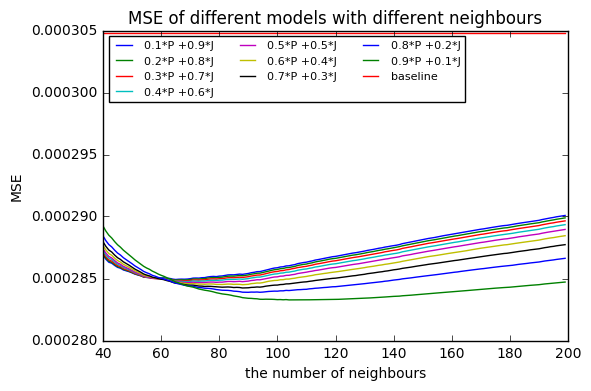

In [36]:
import pylab as pl
res = [[]for _ in range(9)]
resbl = MSE(bl, te_scores)
for i in range(9):
    
    file_name = "res" + str(i+1)+".txt"
    f = file(file_name, "r")
    
    for line in f:
        data = line.split()
        for j in range(40,200):
            res[i].append(data[j])
    f.close()
    x = [k for k in range(40,200)]
    pl.plot(x, res[i],label = str(0.1*(i+1))+"*P +" + str(1-0.1*(i+1))+"*J")
pl.plot(x, [resbl for i in range(40,200)],label = "baseline")
pl.legend(fontsize = 8,ncol=3,loc="upper left")
pl.xlabel('the number of neighbours')
pl.ylabel('MSE')
pl.title('MSE of different models with different neighbours')
pl.show()

In [58]:
file_name = "res9.txt"
f = file(file_name, "r")
new_res = []
for line in f:
    data = line.split()
    for j in range(len(data)):
        new_res.append(float(data[j]))
print new_res.index(min(new_res))+1

111


In [ ]:
import pylab as pl
x = []
for i in range(9):
    for j in range(len(MSE_res[i])):
        x.append(j+1)
    pl.plot(x, MSE_res[i])
    pl.title('the MSE of the model' + str(i))
    pl.xlabel('the number of neighbours')
    pl.ylabel('MSE')
    pl.show()

In [ ]:
for i in range(9):
    pl.plot(x[20:], MSE_res[i][20:])
    pl.title('the MSE of the models')
    pl.xlabel('the number of neighbours')
    pl.ylabel('MSE')
    pl.show()

In [49]:
prediction_list = [[None for _ in range(len(tr_set)-1)]for _ in range(9)]
num = 0
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [50]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [51]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [52]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [53]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [ ]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [ ]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [ ]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [ ]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    f.write(str(prediction_list[num][j]))
    f.write("\n")
f.close()

In [ ]:

hit_rate = [[]for _ in range(9)]
for j in range(9):
    f = open("hit_rate" + str(j) + ".txt", "w")
    
    for i in range(100):
        
        predicted_recom = recommend_dic(tr_scores, prediction_list[j][i])
        res = {}
        for p_name in real_recom:
            pre_set = set(predicted_recom[p_name])
            rea_set = set(real_recom[p_name])
            res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
        hit_rate[j].append(sum(res.values())/len(res.values()))
        f.write(str(hit_rate[j][-1])+' ')
        print "Hit rate of "+ str(j+1)+'th model with ' +str(i+1) + "nn = " + str(hit_rate[j][-1])
    f.close()

In [3]:
def helpFun(neighours):
    index, res = neighours.index('\''), []

    while index < len(neighours):
        next_index = neighours[index + 1:].index('\'') + index + 1
        #print index, next_index+2, next_index+2 + neighours[next_index+2:].index(')'), neighours[next_index+2 : index + 1 + neighours[index + 1:].index(')')]


        nei = neighours[index+1: next_index]
        num = float(neighours[next_index+2:index + 1 + neighours[index + 1:].index(')')])

        res.append((nei, num))
        if '\'' not in  neighours[next_index + 1:]:
            break
        index = neighours[next_index + 1:].index('\'') + next_index + 1

    return res

 

In [4]:
def load_neighbours(num):
    f = file("/Users/Kiki/Downloads/Recommender-System-Project--master/model" + str(num)+".txt", "r")
    index,dic  = 2,{}
    for line in f:
        counter  =1
        store = []
        while index < len(line):
            counter+=1
            next_index = line[index+1:].index('\'') + index+1
            left_bra=line[index+1:].index('[') + index
            right_bra = line[index+1:].index(']') + index+1
            #print line[index:next_index]
            dic[line[index:next_index]] = helpFun(line[left_bra : right_bra+1])
            store.append(line[left_bra : right_bra+1])
            if '\'' not in line[right_bra:]:
                break
            index = line[right_bra:].index('\'') +right_bra+1
    f.close()
    return dic

In [5]:
neighbours = []
for i in range(1,10):
    neighbours.append(load_neighbours(i))

In [13]:
def helpFun2(neighours):
    neighours = neighours.replace(" ", "")
    neighours = neighours[1:-1]

    res =  {}

    data = neighours.split(",")
    
    for i in range(len(data)):

        res[data[i].split(":")[0][1:-1]] = float(data[i].split(":")[1])
    return res


In [7]:
def load_set(url):
    f = file(url, "r")
    index,dic =2, {}
    
    for line in f:

        while index < len(line):
            next_index = line[index+1:].index('\'') + index+1
            left_bra=line[index+1:].index('{') + index
            right_bra = line[index+1:].index('}') + index+1
            dic[line[index:next_index]] = helpFun2(line[left_bra : right_bra+1])
            
            if '\'' not in line[right_bra:]:
                break
            index = line[right_bra:].index('\'') +right_bra+1
    
    return dic


In [8]:
te_scores  = load_set("/Users/Kiki/Downloads/Recommender-System-Project--master/te_scores.txt")


In [9]:
tr_scores  = load_set("/Users/Kiki/Downloads/Recommender-System-Project--master/tr_scores.txt")

In [10]:
prediction_list = [[None for _ in range(len(tr_scores)-1)]for _ in range(9)]

In [14]:
num = 6


f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    for pre in prediction_list[num][j]:
        f.write(str(pre)+" ")
    f.write("\n")
f.close()

In [15]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    for pre in prediction_list[num][j]:
        f.write(str(pre)+" ")
    f.write("\n")
f.close()

In [16]:
num += 1
f = open("prediction" + str(num) + ".txt", "w") 
for j in range(100):
    prediction_list[num][j] = prediction(tr_scores, neighbours[num], te_scores,j)
    for pre in prediction_list[num][j]:
        f.write(str(pre)+" ")
    f.write("\n")
f.close()

In [17]:
def load_pre(url):
    f = file(url, "r")
    index, res = 2, []
    count = 1
    for line in f:
        dic = {}

        count += 1
        while index < len(line):


            next_index = line[index + 1:].index('\'') + index + 1
            left_bra = line[next_index + 1:].index('{') + next_index + 1
            right_bra = line[left_bra + 1:].index('}') + left_bra + 1


            dic[line[index:next_index]] = helpFun2(line[left_bra: right_bra + 1])

            if '\'' not in line[right_bra:]:
                break
            index = line[right_bra:].index('\'') + right_bra + 1
        res.append(dic)
    return res

In [19]:
for i in range(6):
    prediction_list[i]  = load_pre("/Users/Kiki/Downloads/Recommender-System-Project--master/prediction"+str(i)+".txt")

In [23]:

hit_rate = [[]for _ in range(9)]
for j in range(9):
    f = open("hit_rate" + str(j) + ".txt", "w")
    
    for i in range(100):
        
        predicted_recom = recommend_dic(tr_scores, prediction_list[j][i])
        res = {}
        for p_name in real_recom:
            pre_set = set(predicted_recom[p_name])
            rea_set = set(real_recom[p_name])
            res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
        hit_rate[j].append(sum(res.values())/len(res.values()))
        f.write(str(hit_rate[j][-1])+' ')
        print "Hit rate of "+ str(j+1)+'th model with ' +str(i+1) + "nn = " + str(hit_rate[j][-1])
    f.close()

Hit rate of 1th model with 1nn = 0.844073705091
Hit rate of 1th model with 2nn = 0.841121939671
Hit rate of 1th model with 3nn = 0.840621129111
Hit rate of 1th model with 4nn = 0.841449058708
Hit rate of 1th model with 5nn = 0.841431689556
Hit rate of 1th model with 6nn = 0.84157229698
Hit rate of 1th model with 7nn = 0.841579327351
Hit rate of 1th model with 8nn = 0.841579327351
Hit rate of 1th model with 9nn = 0.841579327351
Hit rate of 1th model with 10nn = 0.841579327351
Hit rate of 1th model with 11nn = 0.841686437124
Hit rate of 1th model with 12nn = 0.841686437124
Hit rate of 1th model with 13nn = 0.841686437124
Hit rate of 1th model with 14nn = 0.841686437124
Hit rate of 1th model with 15nn = 0.841309140536
Hit rate of 1th model with 16nn = 0.841637224525
Hit rate of 1th model with 17nn = 0.841686437124
Hit rate of 1th model with 18nn = 0.841827044548
Hit rate of 1th model with 19nn = 0.841769147373
Hit rate of 1th model with 20nn = 0.841769147373
Hit rate of 1th model with 21n

In [40]:
predicted_recom = recommend_dic(tr_scores, bl)
res = {}
for p_name in real_recom:
    pre_set = set(predicted_recom[p_name])
    rea_set = set(real_recom[p_name])
    res[p_name] = 1.0*len(pre_set.intersection(rea_set))/len(rea_set)
hit_rate_bl = sum(res.values())/len(res.values())

print "Hit rate of baseline: " +  str(hit_rate_bl)

Hit rate of baseline: 0.846779789867


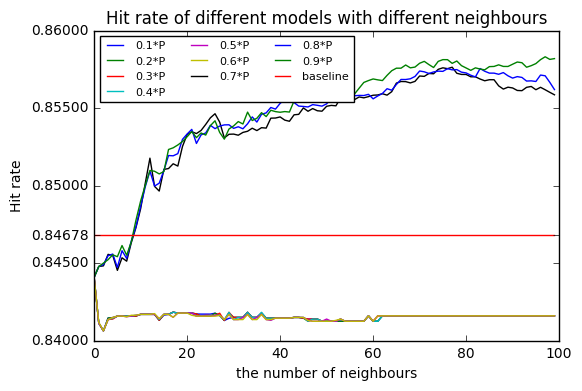

In [44]:

import pylab as pl
res = [[]for _ in range(9)]
for i in range(9):
    file_name = "hit_rate" + str(i)+".txt"
    f = file(file_name, "r")
    
    for line in f:
        data = line.split()
        for j in range(len(data)):
            res[i].append(data[j])
    f.close()
    x = [k for k in range(len(data))]
    pl.plot(x, res[i],label = str(0.1*(i+1))+"*P")
pl.plot(x, [hit_rate_bl for i in range(100)],label = "baseline")
pl.legend(fontsize = 8,ncol=3,loc="upper left")
pl.xlabel('the number of neighbours')
pl.yticks([0.840, 0.845,0.846779789867, 0.850,0.855, 0.860])
pl.ylabel('Hit rate')
pl.title('Hit rate of different models with different neighbours')
pl.show()

Hit rate of baseline: 0.846779789867
